In [1]:
import pandas as pd
import matplotlib.pyplot as plt

#Understand the dataset and perform data checks
data = pd.read_csv("ab_test_data1.csv")
print(data.head())

         DATE  Userid  Variant  Purchases  Total_purchased_amount  \
0  2024/05/10   20295        2         21                       4   
1  2024/04/08    6428        2          6                       0   
2  2024/05/08   59675        2        129                      24   
3  2024/05/14   30994        2       2757                     526   
4  2024/05/14   55427        2        462                      52   

   Return_status  
0              2  
1              2  
2              2  
3              2  
4              2  


In [2]:
# Checking for missing values
print(data.isnull().sum())

DATE                      0
Userid                    0
Variant                   0
Purchases                 0
Total_purchased_amount    0
Return_status             0
dtype: int64


In [3]:
# Checking the data types of each column
print(data.dtypes)

DATE                      object
Userid                     int64
Variant                    int64
Purchases                  int64
Total_purchased_amount     int64
Return_status              int64
dtype: object


In [4]:
# Checking the summary statistics for numeric columns
print(data.describe())

             Userid       Variant     Purchases  Total_purchased_amount  \
count  79999.000000  79999.000000  79999.000000            79999.000000   
mean   32265.302754      1.995450    462.009675               69.097939   
std    18695.937262      0.822463    848.188258              414.207412   
min        1.000000      1.000000      3.000000                0.000000   
25%    16088.000000      1.000000     57.000000                3.000000   
50%    32147.000000      2.000000    165.000000               12.000000   
75%    48505.000000      3.000000    510.000000               43.000000   
max    64763.000000      3.000000  22779.000000            48792.000000   

       Return_status  
count   79999.000000  
mean        1.995450  
std         0.822463  
min         1.000000  
25%         1.000000  
50%         2.000000  
75%         3.000000  
max         3.000000  


In [5]:
# Step 2: Calculating and comparing daily total revenue for each game version
daily_revenue = data.groupby('Variant')['Total_purchased_amount'].sum()

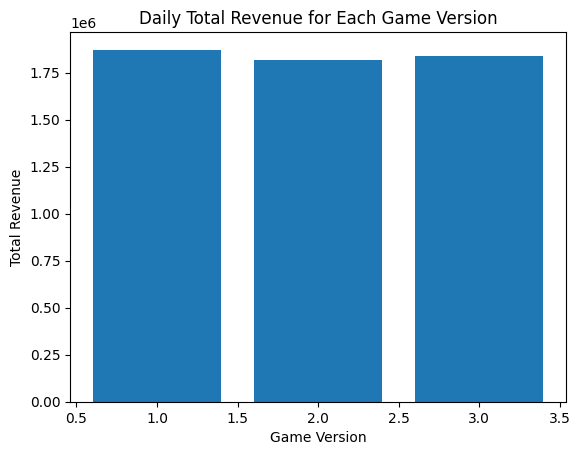

In [6]:
# Visualizing daily total revenue for each game version
plt.bar(daily_revenue.index, daily_revenue.values)
plt.xlabel("Game Version")
plt.ylabel("Total Revenue")
plt.title("Daily Total Revenue for Each Game Version")
plt.show()

In [7]:
import seaborn as sns

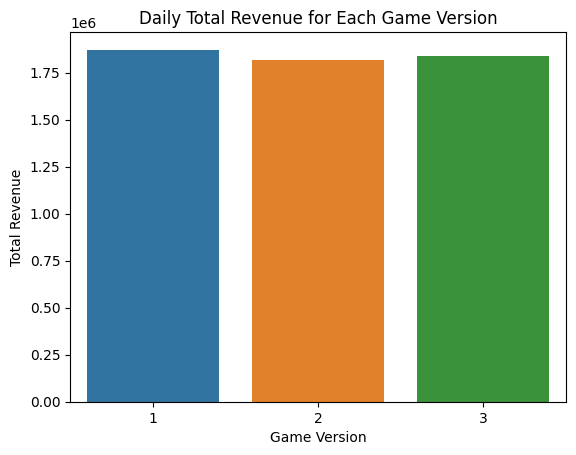

In [8]:
sns.barplot(x=daily_revenue.index, y=daily_revenue.values)
plt.xlabel("Game Version")
plt.ylabel("Total Revenue")
plt.title("Daily Total Revenue for Each Game Version")
plt.show()

In [9]:
# Step 3: Analyzing user behavior differences in single purchase values and number of purchases
# Split data by game version
data_version_A = data[data['Variant'] == 'A']
data_version_B = data[data['Variant'] == 'B']
data_version_C = data[data['Variant'] == 'C']

In [13]:
# Performing one-way ANOVA for single purchase values
# Importing the f_oneway function from scipy.stats
from scipy.stats import f_oneway
f_statistic_sp, p_value_sp = f_oneway(data_version_A['Total_purchased_amount'],
                                      data_version_B['Total_purchased_amount'],
                                      data_version_C['Total_purchased_amount'])

print("One-way ANOVA for Single Purchase Values:")
print("F-statistic:", f_statistic_sp)
print("P-value:", p_value_sp)

One-way ANOVA for Single Purchase Values:
F-statistic: nan
P-value: nan


In [14]:
# Performing a one-way ANOVA for number of purchases
f_statistic_np, p_value_np = f_oneway(data_version_A['Purchases'],
                                      data_version_B['Purchases'],
                                      data_version_C['Purchases'])

print("One-way ANOVA for Number of Purchases:")
print("F-statistic:", f_statistic_np)
print("P-value:", p_value_np)

One-way ANOVA for Number of Purchases:
F-statistic: nan
P-value: nan


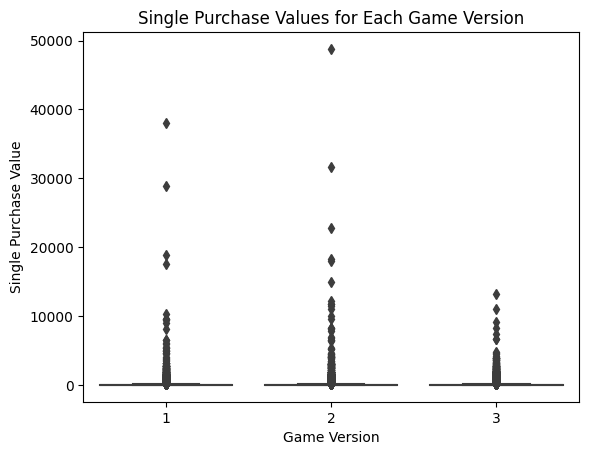

In [15]:
# User Behavior Analysis

# Single purchase values
sns.boxplot(x='Variant', y='Total_purchased_amount', data=data)
plt.xlabel("Game Version")
plt.ylabel("Single Purchase Value")
plt.title("Single Purchase Values for Each Game Version")
plt.show()

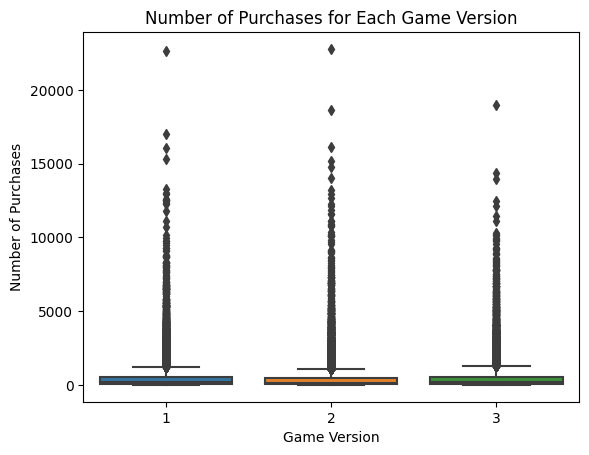

In [16]:
# Number of purchases
sns.boxplot(x='Variant', y='Purchases', data=data)
plt.xlabel("Game Version")
plt.ylabel("Number of Purchases")
plt.title("Number of Purchases for Each Game Version")
plt.show()

In [18]:
from scipy.stats import f_oneway, ttest_ind, mannwhitneyu, chi2_contingency

contingency_table = pd.crosstab(data['Variant'],  data['Total_purchased_amount'])
chi2_stat, p_value_retention, _, _ = chi2_contingency(contingency_table)
print("Chi-square Test for Retention Rates:")
print("Chi-square statistic:", chi2_stat)
print("P-value:", p_value_retention)

Chi-square Test for Retention Rates:
Chi-square statistic: 2978.227938577752
P-value: 0.5876204844618378


In [22]:
if 'Return_status' in data.columns:
    # Create a contingency table for retention rates
    contingency_table = pd.crosstab(data['Variant'], data['Return_status'])
    
    # Calculate retention rates
    retention_rates = contingency_table.iloc[:, 1] / (contingency_table.iloc[:, 2] + contingency_table.iloc[:, 1])
else:
    # If 'Return_status' column is not present, set retention_rates to None
    retention_rates = None

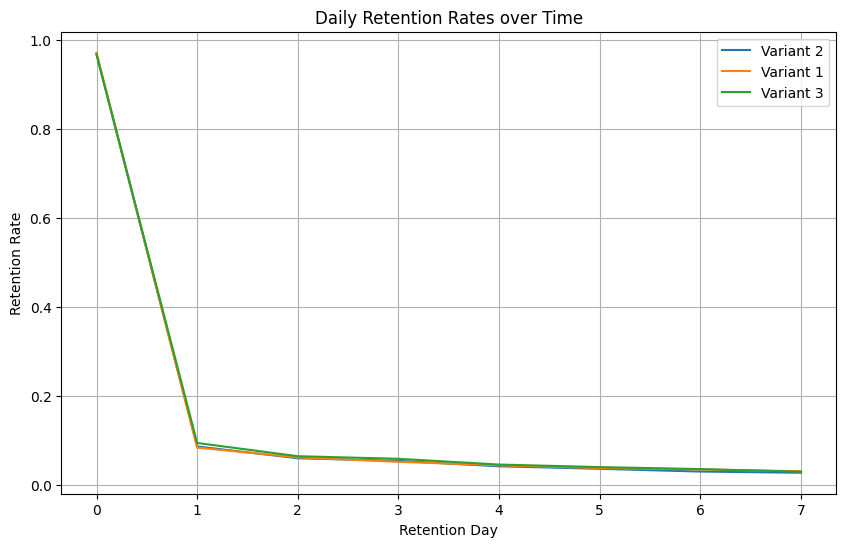

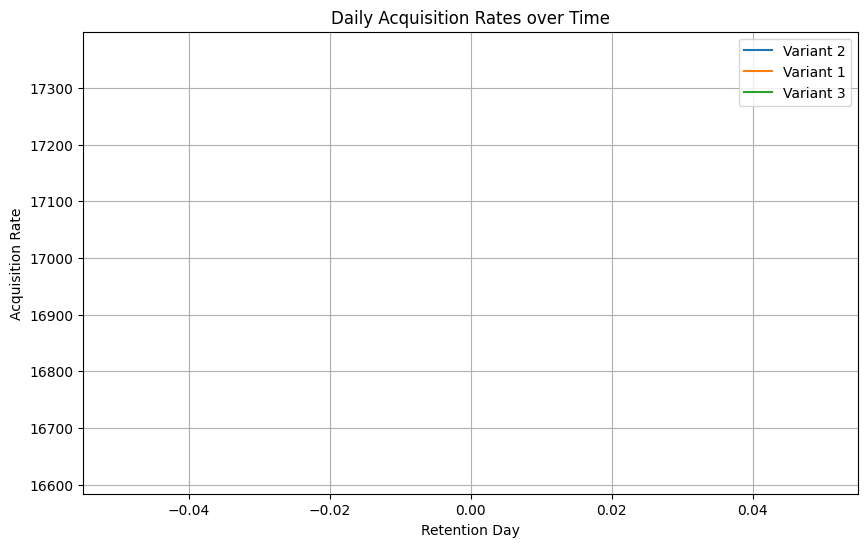

In [27]:
cohorts = data.groupby('Userid')['DATE'].min().reset_index()
cohorts.rename(columns={'DATE': 'Acquisition Date'}, inplace=True)

# We will Merge cohorts with the original data to get the player's acquisition date
data = data.merge(cohorts, on='Userid')

# Step 3: in this step we will Calculate daily retention and acquisition rates for each cohort
# For simplicity, let's consider retention and acquisition for a 7-day period
retention_days = 7
data['Retention Day'] = (pd.to_datetime(data['DATE']) - pd.to_datetime(data['Acquisition Date'])).dt.days

# We will Calculate retention rates for each cohort and day
retention_rates = data[data['Retention Day'] <= retention_days].groupby(['Variant', 'Retention Day'])['Userid'].nunique() / data.groupby(['Variant'])['Userid'].nunique()

# We will Calculate acquisition rates for each cohort and day
acquisition_rates = data[data['Retention Day'] == 0].groupby(['Variant', 'Retention Day'])['Userid'].nunique()

# Step 4: then we will Visualize the results using line plots
plt.figure(figsize=(10, 6))
for variant in data['Variant'].unique():
    plt.plot(retention_rates.loc[variant].index, retention_rates.loc[variant], label=f'Variant {variant}')
plt.xlabel('Retention Day')
plt.ylabel('Retention Rate')
plt.title('Daily Retention Rates over Time')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for variant in data['Variant'].unique():
    plt.plot(acquisition_rates.loc[variant].index, acquisition_rates.loc[variant], label=f'Variant {variant}')
plt.xlabel('Retention Day')
plt.ylabel('Acquisition Rate')
plt.title('Daily Acquisition Rates over Time')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Step 5: Calculate and compare retention rates for each game version
if 'Return_status' in data.columns:
    # Create a contingency table for retention rates
    contingency_table = pd.crosstab(data['Variant'], data['Return_status'])
    
    # Perform chi-square test of independence
    chi2_stat, p_value_retention, _, _ = chi2_contingency(contingency_table)
    
    # Calculate retention rates
    retention_rates = contingency_table.iloc[:, 1] / (contingency_table.iloc[:, 2] + contingency_table.iloc[:, 1])
else:
    chi2_stat, p_value_retention, retention_rates = None, None, None

# Print the results
if chi2_stat is not None and p_value_retention is not None and retention_rates is not None:
    print("Chi-square Test for Retention Rates:")
    print("Chi-square statistic:", chi2_stat)
    print("P-value:", p_value_retention)
    print("Retention Rates:")
    print(retention_rates)
else:
    print("Retention rates analysis cannot be performed due to missing data.")

Chi-square Test for Retention Rates:
Chi-square statistic: 159998.0
P-value: 0.0
Retention Rates:
Variant
1    NaN
2    1.0
3    0.0
dtype: float64
